# ElasticNet

In [1]:
%config IPCompleter.greedy=True
import helper ## own utils func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, tree, linear_model
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
#pd.DataFrame(result_pd_RF).to_csv('resultRF.csv',index = False)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import os
%matplotlib inline 
import pylab 
import scipy.stats as stats
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
plt.style.use('ggplot')
#This line force the graph print out in this jupyter Notebook

c:\programdata\anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
c:\programdata\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
testset = pd.read_csv('test.csv')
trainset = pd.read_csv('train.csv')
trainset.isnull().sum()
## Some features have almost all null in every rows, so I will remove null> 1000 for cleaning the features a little bit.
features = trainset.columns.values
remove_features = trainset.columns[trainset.isnull().sum()>1000]
testset = testset.drop(remove_features,1)
testset_id = testset['Id']
testset = testset.drop('Id', 1)
trainset_id = trainset['Id']
trainset = trainset.drop('Id', 1)
## GarageCars has a higher correlation, so Garage Area and GarageYearBlt will be dropped.
## TotalBsmtSF has a higher correlation with 1stFlrSF, so it will be dropped as well.
trainset = trainset.drop(['1stFlrSF','GarageArea','GarageYrBlt'],1)
testset = testset.drop(['1stFlrSF','GarageArea','GarageYrBlt'],1)

## Drop some columns that only have 1 class for most data
drop_cols = ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']
trainset = trainset.drop(drop_cols, 1)
testset = testset.drop(drop_cols, 1)
trainset['MSSubClass'] = trainset['MSSubClass'].astype('category')
testset['MSSubClass'] = testset['MSSubClass'].astype('category')
#low_var_cat = [col for col in train.select_dtypes(exclude=['number']) if 1 - sum(train[col] == mode(train[col]))/len(train) < 0.03]
#low_var_cat




trainset['SalePrice'] =np.log(trainset['SalePrice'])
train_labels = trainset['SalePrice']
trainset = trainset.drop('SalePrice',1)

from sklearn.model_selection import train_test_split
testset_index = range(len(trainset),len(trainset) + len(testset))

trainset_index, validset_index = train_test_split(range(len(trainset)),
                                    random_state = 42 , test_size = 0.3)
masterset = pd.concat([trainset,testset], axis = 0)
masterset_backup = masterset
# Getting Dummies from all other categorical vars
for col in masterset.dtypes[masterset.dtypes == 'object'].index:
    for_dummy = masterset.pop(col)
    masterset = pd.concat([masterset, pd.get_dummies(for_dummy, prefix=col)], axis=1)
    train_labels_full = train_labels
    
## Drop columns which has very few sample in trainset/testset
#a=masterset.iloc[testset_index].sum()
#b=masterset.iloc[range(len(trainset))].sum()
trainset_nonexist_features = masterset.iloc[range(len(trainset))].sum()<10
testset_nonexist_features = masterset.iloc[testset_index].sum()<10
nonexist_features = masterset.columns[trainset_nonexist_features |
                                      testset_nonexist_features].values
masterset= masterset.drop(nonexist_features, axis = 1)


train_features_full = masterset.iloc[range(len(trainset))]
train_features = masterset.iloc[trainset_index] 
test_features = masterset.iloc[testset_index]
valid_features = masterset.iloc[validset_index]

## Take a copy of it will be a reference of train_labels
valid_labels = train_labels[validset_index].copy() 
train_labels = train_labels[trainset_index]

col = train_features.columns.values
print(train_features.shape)
print(test_features.shape)

(1022, 197)
(1459, 197)


In [14]:
## RandomForest
from sklearn import linear_model
## Model
EN = linear_model.ElasticNetCV(  random_state = 42 )
PipeEN = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', MinMaxScaler()),
        ('EN', EN)
    ])
# estimator parameters

alphas = [50]
l1_ratio = [0.0001, 0.001, 0.01, 0.1,0.5,1]

param_grid_EN = {             
              'imp__strategy': ['mean','median'],                         
            'EN__n_alphas' :alphas, 
            'EN__l1_ratio' : l1_ratio
               }
# set model parameters to grid search object
gridCV_EN = GridSearchCV(estimator = PipeEN, 
                             param_grid = param_grid_EN,                            
                             scoring = 'neg_mean_squared_error',
                             cv = 3)

        
# train the model
gridCV_EN.fit(train_features, train_labels)


print(gridCV_EN.best_params_)


{'EN__l1_ratio': 0.5, 'EN__n_alphas': 50, 'imp__strategy': 'mean'}


Cross Val (Train set) [ 0.13179765  0.23878763  0.15079812  0.12251829  0.12418429]
Cross Val (valid set) [ 0.10835931  0.14808882  0.16192695  0.10320444  0.12995711]
Accuracy Val(Train set) 0.901581662193
Accuracy Val (Valid set) 0.887354607375
Root Mean Squarted Log Error (Train set):  0.123512744891
Root Mean Squarted Log Error (Valid set):  0.138238413124


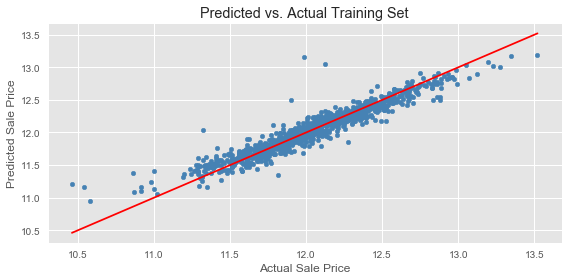

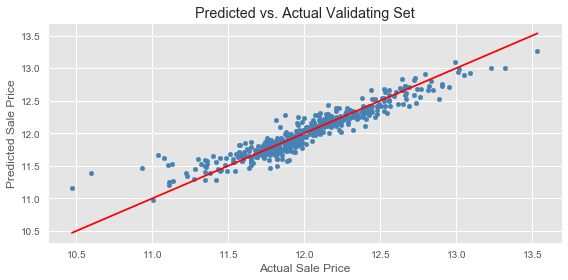

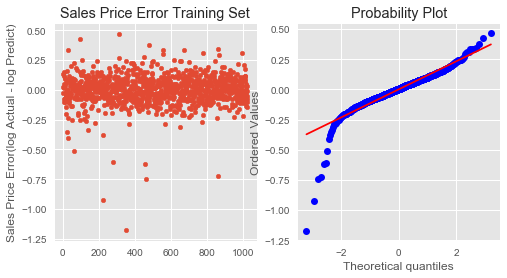

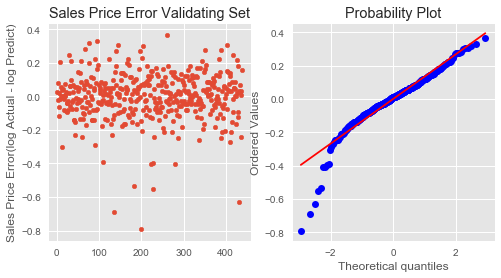

In [15]:
## Running test
helper.summary(gridCV_EN.best_estimator_,train_features, train_labels, valid_features, valid_labels)

In [16]:
import importlib
importlib.reload(helper)
import helper

In [17]:
import pickle
# Save the model if rerun above cell for searching hyperparameters
with open('model_EN.pkl', 'wb') as source:    
    s = pickle.dump(gridCV_EN.best_estimator_, source)

Cross Val (Train set) [ 0.13179765  0.23878763  0.15079812  0.12251829  0.12418429]
Cross Val (valid set) [ 0.10835931  0.14808882  0.16192695  0.10320444  0.12995711]
Accuracy Val(Train set) 0.901581662193
Accuracy Val (Valid set) 0.887354607375
Root Mean Squarted Log Error (Train set):  0.123512744891
Root Mean Squarted Log Error (Valid set):  0.138238413124


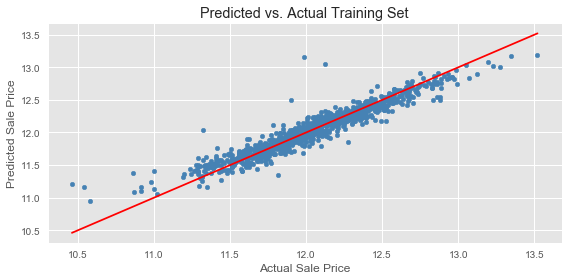

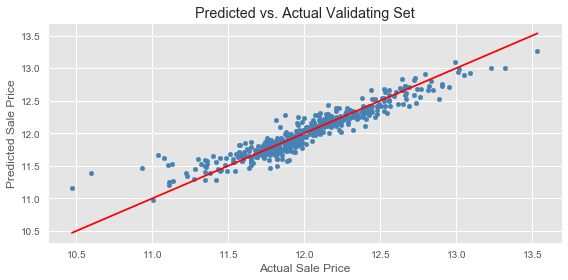

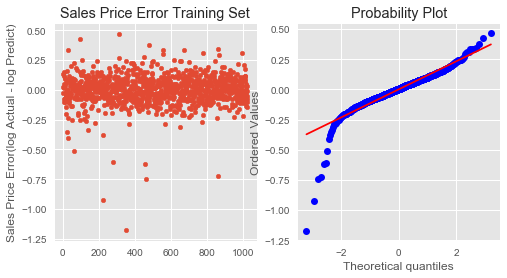

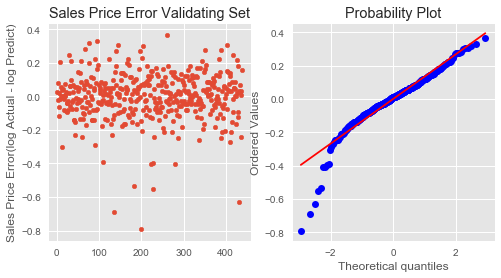

In [18]:
with open('model_EN.pkl','rb') as load:
    model_EN = pickle.load(load)
helper.summary(model_EN,train_features, train_labels, valid_features, valid_labels)

In [19]:
model_EN.fit(train_features_full, train_labels_full)
result_EN = model_EN.predict(test_features)

In [20]:
result_EN = gridCV_EN.best_estimator_.predict(test_features)
## Output result, match the require format
result_pd= pd.DataFrame(np.array(list(zip(testset_index,result_EN))),
                        columns=['Id','SalePrice']) ## Id start from 1
result_pd.Id = result_pd.Id.astype('int') + 1 ## Id = index + 1
result_pd['SalePrice'] = result_pd['SalePrice'].apply(lambda x: np.e**(x))
result_pd[0:5]
pd.DataFrame(result_pd).to_csv('resultEN.csv',index = False)